In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import os

from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from keras import regularizers


In [12]:
from ipynb.fs.full.DatasetManage import read_and_store_data
from ipynb.fs.full.FeatureExtraction import feature_extraction

Parameters

In [13]:
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'seizure']

dataset = 'CHB_MIT'
csvImportFile = 'CHB.csv'
csvExportFile = 'CHB.csv'
sample_rate = 256
time_window = 2
step = time_window * sample_rate

test_ratio = 0.3 # ratio to split dataset into training and testing sets
val_ratio = 0.2 # ratio to split dataset into validation and training sets

pca_tolerance = 0.9 # desired percentage of variation in the data preserved

undersampling_rate = 0.2 # undersampling rate for Cluster Centroids

oversampling_neighbors = 11 # size of neighbourhood for K-nearest neighbours method

Create training and test sets

In [9]:
# Here we define a method to split the dataset into training and testing sets, also returning the train/test
# indexes for splitting the dataset into K folds for the K-fold cross validation

def trainTestData_1 (features, test_ratio, k_fold):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size = test_ratio, shuffle = True, random_state=42)
    kf = KFold(n_splits = k_fold, shuffle = True)
    x_train = np.reshape(x_tr.values, (x_tr.shape[0], 1, x_tr.shape[1]))
    y_train = y_tr.values.astype(int)
    x_test = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_test = y_ts.values.astype(int)
    return x_train, x_test, y_train, y_test, kf

Create training, validation and test sets

In [14]:
# Here we define a method to split the dataset into training, validationa and testing sets

def trainTestData_2 (features, test_ratio, val_ratio):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_1, x_ts, y_1, y_ts = train_test_split(x, y, test_size = test_ratio, random_state=42)
    x_tr, x_v, y_tr, y_v = train_test_split(x_1, y_1, test_size = val_ratio, random_state=42)
    x_train = np.reshape(x_tr.values, (x_tr.shape[0], 1, x_tr.shape[1]))
    y_train = y_tr.values.astype(int)
    x_val = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_val = y_ts.values.astype(int)
    x_test = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_test = y_ts.values.astype(int)
    return x_train, x_test, y_train, y_test, x_val, y_val

Read and store data from the .csv file

In [15]:
print('Reading data from', csvImportFile)
df = pd.read_csv(csvImportFile, delimiter = ',', header = 0)

Reading data from CHB.csv


Feature Extraction 

In [5]:
# We compute the features and save them in the Feature.csv file

ft = feature_extraction(df, sample_rate, step, pca_tolerance, undersampling_rate, oversampling_neighbors)

NameError: name 'feature_extraction' is not defined

Train and Test process

In [2]:
ft = pd.read_csv("Features.csv", delimiter = ',', header = 0)

Dataset splitting without validation set

In [16]:
k_fold = 5
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

Dataset splitting with validation set

In [17]:
x_train, x_test, y_train, y_test, x_val, y_val = trainTestData_2 (ft, test_ratio, val_ratio)

Model Checkpoint

In [18]:
dir_name = 'model_checkpoint'

if not os.path.exists(dir_name):
        os.makedirs(dir_name)

save_path = os.path.join(dir_name, 'Vanilla_RNN.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

Stochastic Gradient Descent Optimizer

In [19]:
def optimizer_SGD (initial_learning_rate, decay_steps, decay_rate):
    # We define the optimizer with an initial learning rate
    optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

    # We define the larning rate schedule with an exponential decay, specifying the number of decay steps and the decay rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)
    
    return optimizer, lr_schedule

Plot methods

In [20]:
def plot_2 (history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(train_loss))

    plt.figure()
    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

    model.summary()

Plot method for K-fold validation

In [21]:
def plot_1 (train_loss, train_acc, val_loss, val_acc):
    
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    avg_val_acc = np.mean(train_acc, axis=0)

    # Plot delle curve di apprendimento mediate sulle K fold

    epochs = range(1, len(train_loss[0]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_loss, label='Training loss')
    plt.plot(epochs, avg_val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Avg_loss')
    plt.title('Average train and validation loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_acc, label='Training accuracy')
    plt.plot(epochs, avg_val_acc, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Avg_accuracy')
    plt.title('Average train and validation accuracy')
    plt.legend()
    plt.show()

    model.summary()

In [22]:
# Plot the average loss curve
plt.figure()
for i in range(5):
    plt.plot(train_loss[i])
plt.title('Training Loss - All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(train_acc[i])
plt.title('Training Accuracy - All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'train_loss' is not defined

<Figure size 432x288 with 0 Axes>

GRU 1 layer SGD optimizer

Epoch 1/200
43/63 [===================>..........] - ETA: 0s - loss: 0.7200 - accuracy: 0.6186
Epoch 1: val_loss improved from inf to 0.69626, saving model to model_checkpoint\GRU_1 layer_SGD.h5
63/63 [==============================] - 3s 11ms/step - loss: 0.7307 - accuracy: 0.6006 - val_loss: 0.6963 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6290
Epoch 2: val_loss improved from 0.69626 to 0.65035, saving model to model_checkpoint\GRU_1 layer_SGD.h5
63/63 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.6262 - val_loss: 0.6504 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/200
55/63 [=========================>....] - ETA: 0s - loss: 0.6355 - accuracy: 0.6873
Epoch 3: val_loss improved from 0.65035 to 0.61083, saving model to model_checkpoint\GRU_1 layer_SGD.h5
63/63 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6869 - val_loss: 0.6108 - val_accuracy: 

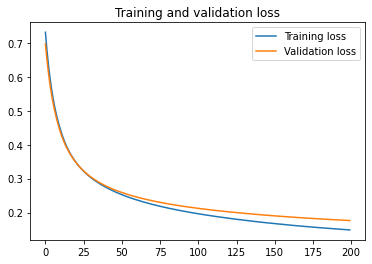

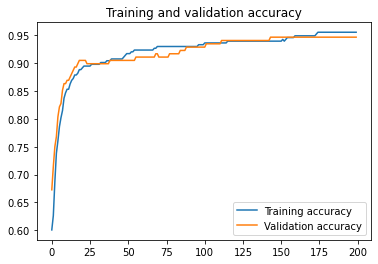

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 32)                11520     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9464
Test Loss: 0.1767757534980774
Test Accuracy: 0.9464285969734192


In [17]:
# This code illustrates the implementation of an enhanced GRU model with a single layer and Stochastic Gradient Descent optimization. 
# The model is trained to solve a binary classification problem

dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_1 layer_SGD.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with a SGD optimizer with an exponential decaying learning rate
optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



GRU 1 layer Adam optimizer 

Epoch 1/200
48/63 [=====================>........] - ETA: 0s - loss: 0.6981 - accuracy: 0.5542
Epoch 1: val_loss improved from inf to 0.70889, saving model to model_checkpoint\GRU_1 layer_Adam.h5
63/63 [==============================] - 3s 10ms/step - loss: 0.6830 - accuracy: 0.5815 - val_loss: 0.7089 - val_accuracy: 0.5476
Epoch 2/200
45/63 [====================>.........] - ETA: 0s - loss: 0.6357 - accuracy: 0.6311
Epoch 2: val_loss improved from 0.70889 to 0.64839, saving model to model_checkpoint\GRU_1 layer_Adam.h5
63/63 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6486 - val_loss: 0.6484 - val_accuracy: 0.6310
Epoch 3/200
53/63 [========================>.....] - ETA: 0s - loss: 0.5851 - accuracy: 0.6981
Epoch 3: val_loss improved from 0.64839 to 0.59753, saving model to model_checkpoint\GRU_1 layer_Adam.h5
63/63 [==============================] - 0s 4ms/step - loss: 0.5635 - accuracy: 0.7284 - val_loss: 0.5975 - val_accuracy: 0.6845
Epoch 4/200
56/6

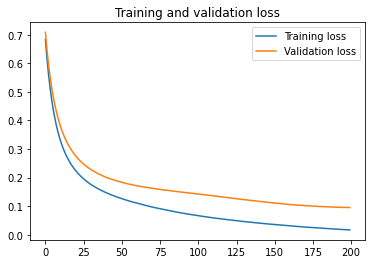

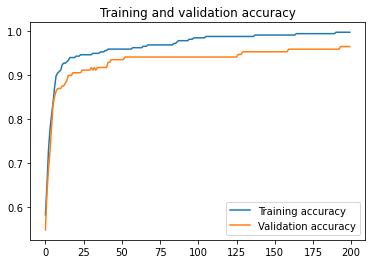

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                11520     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.0950 - accuracy: 0.9643
Test Loss: 0.09504835307598114
Test Accuracy: 0.9642857313156128


In [21]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_1 layer_Adam.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val), callbacks=[callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

GRU 1 layer RMS optimizer

Epoch 1/200
46/63 [====================>.........] - ETA: 0s - loss: 0.7930 - accuracy: 0.3565
Epoch 1: val_loss improved from inf to 0.72199, saving model to model_checkpoint\GRU_1 layer_RMSprop.h5
63/63 [==============================] - 3s 13ms/step - loss: 0.7833 - accuracy: 0.3834 - val_loss: 0.7220 - val_accuracy: 0.5060
Epoch 2/200
55/63 [=========================>....] - ETA: 0s - loss: 0.7248 - accuracy: 0.4691
Epoch 2: val_loss improved from 0.72199 to 0.66277, saving model to model_checkpoint\GRU_1 layer_RMSprop.h5
63/63 [==============================] - 0s 5ms/step - loss: 0.7133 - accuracy: 0.4856 - val_loss: 0.6628 - val_accuracy: 0.6190
Epoch 3/200
47/63 [=====================>........] - ETA: 0s - loss: 0.6561 - accuracy: 0.5745
Epoch 3: val_loss improved from 0.66277 to 0.60938, saving model to model_checkpoint\GRU_1 layer_RMSprop.h5
63/63 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.5974 - val_loss: 0.6094 - val_accuracy: 0.6845
Epoch 4

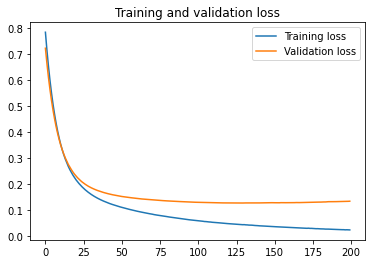

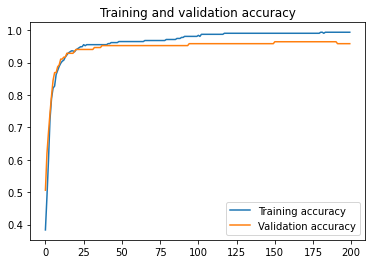

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32)                11520     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 3ms/step - loss: 0.1348 - accuracy: 0.9583
Test Loss: 0.13477586209774017
Test Accuracy: 0.9583333134651184


In [23]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_1 layer_RMSprop.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val), callbacks=[callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1 layer with dropout Adam

Epoch 1/200
84/90 [===========================>..] - ETA: 0s - loss: 0.7908 - accuracy: 0.4619
Epoch 1: val_loss improved from inf to 0.71700, saving model to model_checkpoint\GRU_1 layer with dropout_Adam.h5
90/90 [==============================] - 3s 10ms/step - loss: 0.7902 - accuracy: 0.4576 - val_loss: 0.7170 - val_accuracy: 0.5833
Epoch 2/200
76/90 [========================>.....] - ETA: 0s - loss: 0.7246 - accuracy: 0.5684
Epoch 2: val_loss improved from 0.71700 to 0.65933, saving model to model_checkpoint\GRU_1 layer with dropout_Adam.h5
90/90 [==============================] - 0s 5ms/step - loss: 0.7189 - accuracy: 0.5670 - val_loss: 0.6593 - val_accuracy: 0.6726
Epoch 3/200
89/90 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6629
Epoch 3: val_loss improved from 0.65933 to 0.60728, saving model to model_checkpoint\GRU_1 layer with dropout_Adam.h5
90/90 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6629 - val_loss: 0.6073 

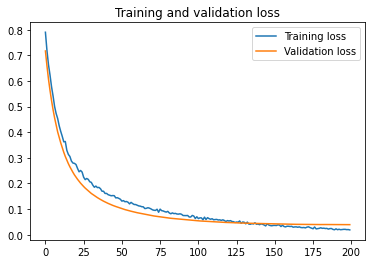

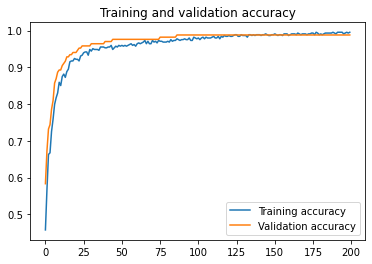

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 32)                11520     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step - loss: 0.0872 - accuracy: 0.9821
Test Loss: 0.08723723143339157
Test Accuracy: 0.9821428656578064


In [36]:
# This code illustrates the implementation of an improved GRU model with dropout regularization and Adam optimization.

dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_1 layer with dropout_Adam.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32,input_shape=(None, x_train.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val), callbacks=[callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1 layer with dropout RMSprop

Epoch 1/200
85/90 [===========================>..] - ETA: 0s - loss: 0.6972 - accuracy: 0.5812
Epoch 1: val_loss improved from inf to 0.64487, saving model to model_checkpoint\GRU_1 layer with dropout_RMSprop.h5
90/90 [==============================] - 4s 10ms/step - loss: 0.6968 - accuracy: 0.5804 - val_loss: 0.6449 - val_accuracy: 0.7143
Epoch 2/200
90/90 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6763
Epoch 2: val_loss improved from 0.64487 to 0.59213, saving model to model_checkpoint\GRU_1 layer with dropout_RMSprop.h5
90/90 [==============================] - 0s 5ms/step - loss: 0.6378 - accuracy: 0.6763 - val_loss: 0.5921 - val_accuracy: 0.7500
Epoch 3/200
83/90 [==========================>...] - ETA: 0s - loss: 0.5972 - accuracy: 0.7277
Epoch 3: val_loss improved from 0.59213 to 0.54478, saving model to model_checkpoint\GRU_1 layer with dropout_RMSprop.h5
90/90 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.7277 - val_loss

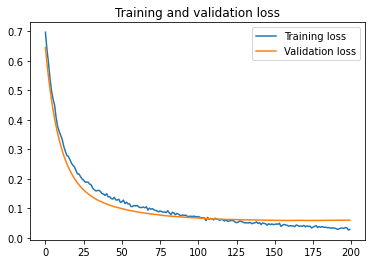

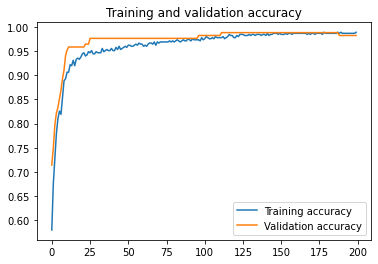

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_26 (GRU)                (None, 32)                11520     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.9643
Test Loss: 0.11047140508890152
Test Accuracy: 0.9642857313156128


In [40]:
# This code illustrates the implementation of an improved GRU model with dropout regularization and Root Mean Square Propagation optimization.

dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_1 layer with dropout_RMSprop.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32,input_shape=(None, x_train.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val), callbacks=[callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

GRU 2 layers SGD

Epoch 1/700
84/90 [===========================>..] - ETA: 0s - loss: 0.6829 - accuracy: 0.5571
Epoch 1: val_loss improved from inf to 0.67686, saving model to model_checkpoint\GRU_2 layer_SGD.h5
90/90 [==============================] - 9s 24ms/step - loss: 0.6817 - accuracy: 0.5625 - val_loss: 0.6769 - val_accuracy: 0.5893 - lr: 0.0010
Epoch 2/700
84/90 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6429
Epoch 2: val_loss improved from 0.67686 to 0.66378, saving model to model_checkpoint\GRU_2 layer_SGD.h5
90/90 [==============================] - 1s 8ms/step - loss: 0.6683 - accuracy: 0.6429 - val_loss: 0.6638 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/700
88/90 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.7091
Epoch 3: val_loss improved from 0.66378 to 0.65128, saving model to model_checkpoint\GRU_2 layer_SGD.h5
90/90 [==============================] - 1s 7ms/step - loss: 0.6555 - accuracy: 0.7098 - val_loss: 0.6513 - val_accuracy: 

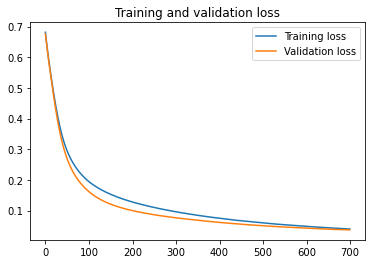

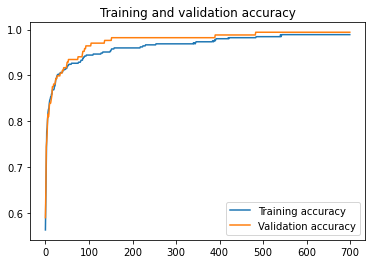

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, None, 32)          11520     
                                                                 
 gru_13 (GRU)                (None, 32)                6336      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,889
Trainable params: 17,889
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.9821
Test Loss: 0.07802385091781616
Test Accuracy: 0.9821428656578064


In [25]:
# This code implements a deep Gated Recurrent Unit (GRU) architecture with two layers, using the SGD optimization.


dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_2 layers_SGD.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1]),return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with a SGD optimizer with an exponential decaying learning rate
optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, batch_size=5, epochs=700, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), callbacks_list])


plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2 layers k fold

Implementing GRU with K-fold

Epoch 1: val_loss improved from inf to 0.73069, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 2: val_loss improved from 0.73069 to 0.71418, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 3: val_loss improved from 0.71418 to 0.69845, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 4: val_loss improved from 0.69845 to 0.68319, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 5: val_loss improved from 0.68319 to 0.66849, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 6: val_loss improved from 0.66849 to 0.65412, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 7: val_loss improved from 0.65412 to 0.64010, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 8: val_loss improved from 0.64010 to 0.62648, saving model to model_checkpoint\GRU_2 layers k fold.h5

Epoch 9: val_loss improved from 0.62648 to 0.61321, saving model to model_checkpoint\GRU_2 layers k fo

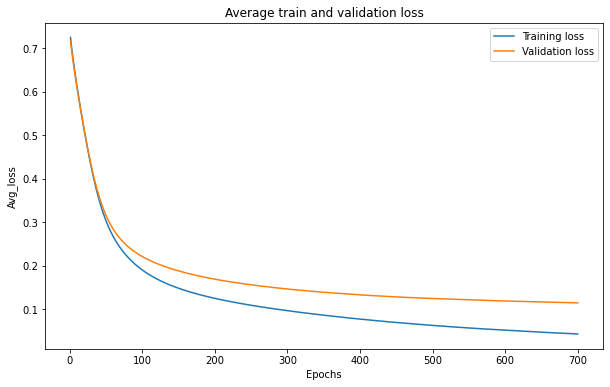

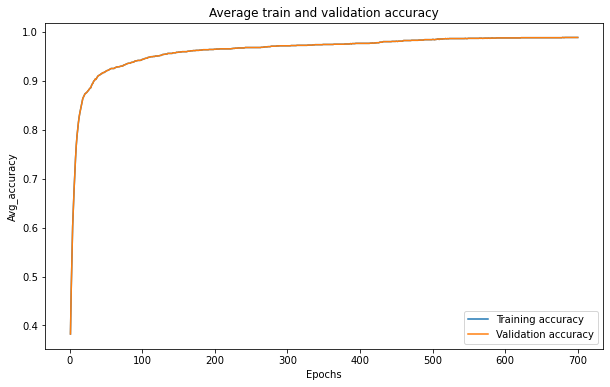

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_35 (GRU)                (None, None, 32)          11520     
                                                                 
 gru_36 (GRU)                (None, 32)                6336      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,889
Trainable params: 17,889
Non-trainable params: 0
_________________________________________________________________
Average accuracy: 0.9554
Average loss: 0.1150


In [41]:
# This code implements a K-Fold Cross Validation technique combined with a deep Gated Recurrent Unit (GRU) architecture. 

dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GRU_2 layers k fold.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

k_fold = 5 # number of folds for the K-fold cross validation
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

# Arrays to store the learning curves at each k-th iteration
val_loss = []
val_acc = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []

print('Implementing GRU with K-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    # Definition of the model
    model = Sequential()
    model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1]),return_sequences=True))
    model.add(layers.GRU(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model with a SGD optimizer with an exponential decaying learning rate
    optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training of the model
    history = model.fit(x_train, y_train, batch_size = 5, epochs = 700, verbose = 0, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), callbacks_list])

    # Store the metrics values for each epoch and for each fold
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])

    # Evaluation of the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Print of the loss and accuracy scores at the end of each fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

end = time.time()
t = round(end - start,2)
print('GRU finished in', t,'sec\n')

# Plot of the average learning curves
plot_1(train_loss, train_acc, val_loss, val_acc)

# Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')